# ICD10CM Mapping Viewer
This notebook streamlines the retrieval of ICD-10-CM to OHDSI Standardized Vocabularies mappings and their associated metadata.

## Features
* Automated Data Fetching: Download the XLSX mapping file directly from the N3C GitHub repository.
* Data Preservation: Save the mapping file to a CSV format for subsequent use.
* Mapping Search: Swiftly explore mappings you need.
* Extended Features: Benefit from additional tools, including statistics, mapping file quality assurance (QA), and visual dashboards.

Run the cell below to initiate the process and use the search bar for querying specific mappings.

In [1]:
import pandas as pd
import requests
import ipywidgets as widgets
from IPython.display import display

# Download the file, customize the link if needed
url = 'https://github.com/TuftsCTSI/N3C/docs/icd10cm-to-ohdsi-mappings/ICD10CM-to-OHDSI-Mappings.xlsx?raw=true'
# 'https://github.com/TuftsCTSI/N3C/docs/icd10cm-to-omop-on-sssom/ICD10CM-to-OMOP-on-SSSOM_v.2.1.xlsm?raw=true'
file_path = "temp_file.xlsm"

response = requests.get(url)
with open(file_path, 'wb') as f:
    f.write(response.content)

# Convert the 'Mapping' tab to a DataFrame
data = pd.read_excel(file_path, sheet_name="ICD10CM-to-OHDSI-Mappings", engine='openpyxl')

# Save the 'Mapping' tab data to CSV in the specified directory
data.to_csv("C:\\Python310\\csv\\ICD10CM-to-OHDSI-Mappings.csv", index=False)

# Search optimization on specified columns
SEARCH_COLUMNS = ['subject_category_range','subject_category','subject_id','subject_label','predicate_id',
                  'confidence','object_id','object_label','object_vocabulary','mapping_justification',
                  'mapping_date']

def search_csv(search_query):
    # Filter the DataFrame based on the search query in specific columns
    mask = pd.concat([data[col].astype(str).str.contains(search_query, case=False) for col in SEARCH_COLUMNS], axis=1).any(axis=1)
    result = data[mask]
    
    # Display the result
    display(result)

# Create and link the search bar widget
search_bar = widgets.Text(
    value='',
    placeholder='Type ICD code or description',
    description='SEARCH',
    disabled=False
)

widgets.interactive(search_csv, search_query=search_bar)

interactive(children=(Text(value='', description='SEARCH', placeholder='Type ICD code or description'), Output…

## Supplemental Functionality

### Summary Statistics

In [68]:
import pandas as pd
import requests
from IPython.display import display, HTML

GITHUB_URL= 'https://github.com/TuftsCTSI/N3C/docs/icd10cm-to-ohdsi-mappings/ICD10CM-to-OHDSI-Mappings.xlsx?raw=true'

# Download and read the GitHub file into a DataFrame
response = requests.get(GITHUB_URL)
with open("temp_mapping_file.xlsx", "wb") as f:
    f.write(response.content)
df = pd.read_excel("temp_mapping_file.xlsx")

# Function to display styled DataFrame
def display_styled_df(df, title):
    style_header = {
        "selector": "thead th",
        "props": [
            ("background-color", "black"),
            ("color", "white"),
            ("text-align", "center")
        ]
    }
    df_styled = df.style.set_table_attributes("border=1").set_caption(title).set_table_styles([style_header])
    return df_styled

# 2. Calculate counts of distinct subject_id per each predicate_id
distinct_subjects_per_predicate = df.groupby('predicate_id')['subject_id'].nunique().reset_index().sort_values(by='subject_id', ascending=False)

# 3. Calculate counts of distinct subject_id per each confidence
distinct_subjects_per_confidence = df.groupby('confidence')['subject_id'].nunique().reset_index().sort_values(by='subject_id', ascending=False)

# 4. Calculate counts of distinct subject_id per each mapping_justification
distinct_subjects_per_justification = df.groupby('mapping_justification')['subject_id'].nunique().reset_index().sort_values(by='subject_id', ascending=False)

# 1. Calculate counts of distinct ICD10CM codes per subject_category and overall
distinct_icd10_counts_per_category = df.groupby('subject_category')['subject_id'].nunique().reset_index().sort_values(by='subject_id', ascending=False)
distinct_icd10_total_count = df['subject_id'].nunique()
total_row = pd.DataFrame({'subject_category': ['Total'], 'subject_id': [distinct_icd10_total_count]})
distinct_icd10_counts_per_category = pd.concat([distinct_icd10_counts_per_category, total_row], ignore_index=True)

# Group and Display tables
tables_to_display = [
    display_styled_df(distinct_subjects_per_predicate, "Counts of Distinct Subject ID per Predicate ID"),
    display_styled_df(distinct_subjects_per_confidence, "Counts of Distinct Subject ID per Confidence"),
    display_styled_df(distinct_subjects_per_justification, "Counts of Distinct Subject ID per Mapping Justification"),
    display_styled_df(distinct_icd10_counts_per_category, "Counts of Distinct ICD10CM Codes per Subject Category")
]

for table in tables_to_display:
    display(table)

,predicate_id,subject_id
0,skos:broadMatch,76345
1,skos:exactMatch,10513
3,skos:uncheckedMatch,9912
2,skos:narrowMatch,9
4,skos:unmapped,4
5,skos:wrongMatch,4


,confidence,subject_id
2,0.700000,42795
3,0.900000,33832
4,1.000000,10244
1,0.500000,9912
0,0.000000,4


,mapping_justification,subject_id
6,semapv:ManualMappingCuration,49737
4,semapv:LexicalSimilarityThresholdMatching,21016
3,semapv:LexicalMatching,19448
0,semapv:CompositeMatching,4902
2,semapv:LevenshteinEditDistance,886
1,semapv:DigitSuppression,691
5,semapv:LinkStripping,61


,subject_category,subject_id
0,"Injury, poisoning and certain other consequences of external causes",53909
1,External causes of morbidity,10384
2,Diseases of the musculoskeletal system and connective tissue,8589
3,Diseases of the eye and adnexa,3401
4,"Pregnancy, childbirth and the puerperium",3016
5,Neoplasms,2097
6,Diseases of the circulatory system,1778
7,Factors influencing health status and contact with health services,1736
8,Certain infectious and parasitic diseases,1305
9,"Endocrine, nutritional and metabolic diseases",1203


### Syntactic Checks of the Mapping Table 
When we refer to syntactic checks, we are talking about examining the structure of the mapping table to ensure it adheres to the expected format and conventions regarding mapping metadata. 

For our mapping table, cell do the following:
* ensure that the confidence values lie within the expected range.
* checks for correct predicate_id values, making sure there are not unexpected many-to-one mappings for exact matches.

To initiate the QA run the cell below.


In [61]:
import pandas as pd
import requests

# Download the mapping table from GitHub
url = 'https://github.com/TuftsCTSI/N3C/docs/icd10cm-to-ohdsi-mappings/ICD10CM-to-OHDSI-Mappings.xlsx?raw=true'
mapping_file_path = "temp_mapping_file.xlsm"
response = requests.get(url)
with open(mapping_file_path, 'wb') as f:
    f.write(response.content)
data = pd.read_excel(mapping_file_path, engine='openpyxl')

# Error checking functions
def confidence_error(df):
    st = df.confidence.describe()
    if st['max'] > 1 and st['min'] < 0:
        return 'Error: max confidence cannot be more than 1 and min confidence cannot be less than 0'
    elif st['max'] > 1:
        return 'Error: max confidence cannot be more than 1'
    elif st['min'] < 0:
        return 'Error: min confidence cannot be less than 0'
    else:
        return 'No errors found for the confidence field'

def get_predicates(x):
    if x:
        return 'One to Many'
    else:
        return 'One to One'

def predicate_id_error(df):
    pred = df[['subject_id','predicate_id']].value_counts().rename_axis(['subject_id','predicate_id']).reset_index(name='counts')
    pred['pred'] = pred['counts'].apply(lambda x: x > 1)
    pred['predic_id'] = pred['pred'].map(get_predicates)
    c1 = pred['predic_id'] == 'One to Many'
    c2 = pred['predicate_id'] == 'skos:exactMatch'
    pred_check = pred['subject_id'].where(c1 & c2).dropna().to_list()
    if len(pred_check) == 0:
        return 'No errors found for the predicate_id field'
    else:
        return 'Exact match have One to Many mapping, here are these codes: ' + ', '.join(pred_check)

# Run checks
print(confidence_error(data))
print(predicate_id_error(data))

No errors found for the confidence field
No errors found for the predicate_id field


## Dashboards
### Confidence Distribution
The confidence distribution visualizes the frequency of various confidence scores in the dataset. Each point on the line plot represents the occurrence frequency of a particular confidence score. The x-axis denotes the different confidence values, ranging from the lowest to the highest score, while the y-axis indicates the frequency of each score. Peaks in the graph highlight the most common confidence scores present in the data. This distribution aids in understanding the overall trustworthiness and certainty levels of the data points in ICD10CM to OHDSI mappings.

0.7    75338
0.9    33832
1.0    10601
0.5     9912
0.0        4
Name: confidence, dtype: int64


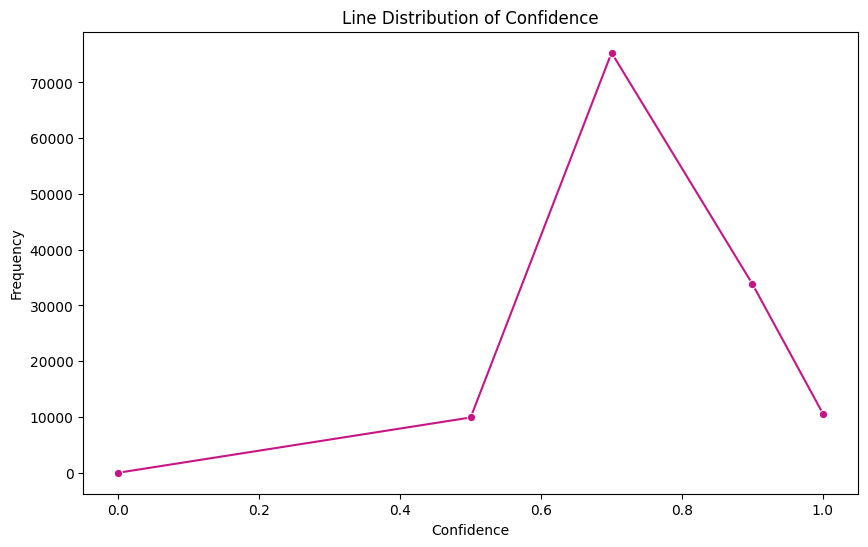

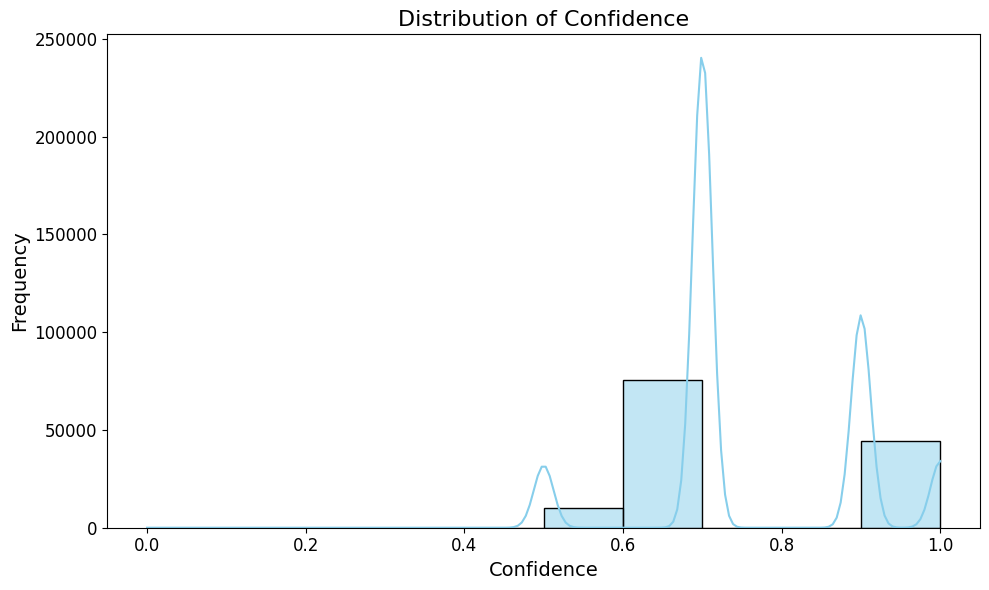

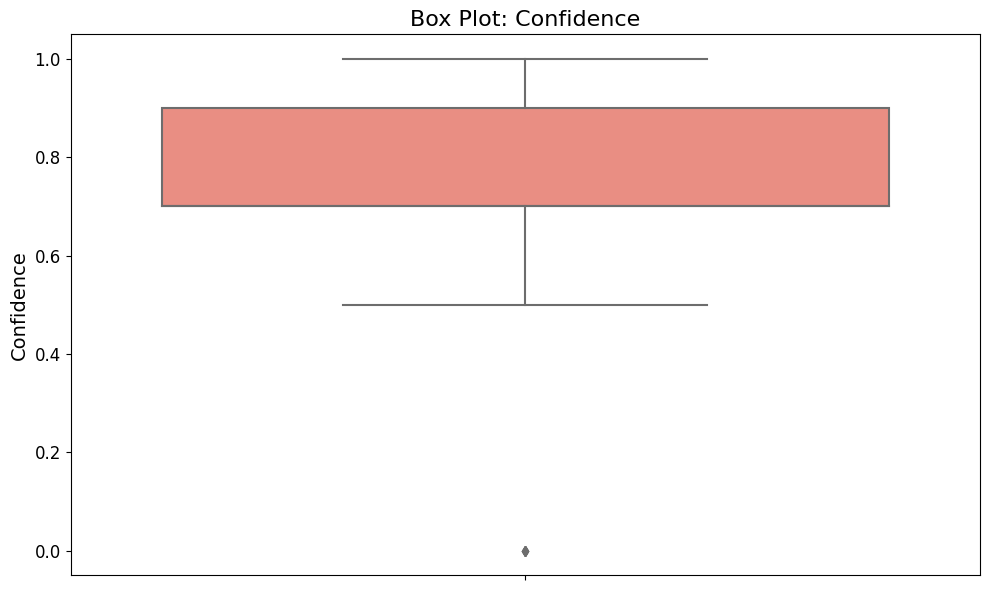

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

def fetch_data_from_url(url, local_path):
    """Fetches data from a given URL and saves it to a local file."""
    response = requests.get(url)
    with open(local_path, 'wb') as f:
        f.write(response.content)

# Fetching the data from the given URL
url = 'https://github.com/TuftsCTSI/N3C/docs/icd10cm-to-ohdsi-mappings/ICD10CM-to-OHDSI-Mappings.xlsx?raw=true'
file_path = "temp_file.xlsm"
fetch_data_from_url(url, file_path)

# Load the data into a pandas DataFrame
data = pd.read_excel(file_path, engine='openpyxl')

# Check and print value counts of confidence
print(data.confidence.value_counts())

# Plotting the line distribution of confidence
plt.figure(figsize=(10, 6))
data_to_plot = data.confidence.value_counts().reset_index()
sns.lineplot(x='index', y='confidence', data=data_to_plot, marker='o', color='mediumvioletred')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Line Distribution of Confidence")
plt.show()

# Set up the figure size
plt.figure(figsize=(10, 6))

# Histogram for 'confidence' column
sns.histplot(data['confidence'], kde=True, color='skyblue', bins=10)
plt.title("Distribution of Confidence", fontsize=16)
plt.xlabel("Confidence", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Box plot for 'confidence' column
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['confidence'], color='salmon')
plt.title("Box Plot: Confidence", fontsize=16)
plt.ylabel("Confidence", fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Predicate Distribution
The Predicate Distribution visualization provides insights into the frequencies of various predicate IDs present in the dataset. Each bar represents a unique predicate_id combined with its relationship type, either 'One to One' or 'One to Many'. The length of the bars indicates the count or occurrence of each predicate_id in the data.

By examining the predicate distribution, users can identify the predominant predicate relationships and their respective frequencies in the mapping. This understanding is pivotal for several reasons:
1. Filtering Exact Matches: It allows for the efficient filtering of exact matches, which are crucial when constructing concept sets.
2. Selection for Standardization: Recognizing which ICD codes should undergo the standardization process and subsequently be integrated into the OHDSI concept hierarchy.
3. Vocabulary Enhancement: The distribution provides insights into potential gaps or areas of improvement in the vocabularies, emphasizing where efforts should be concentrated to refine and enhance the ontology.


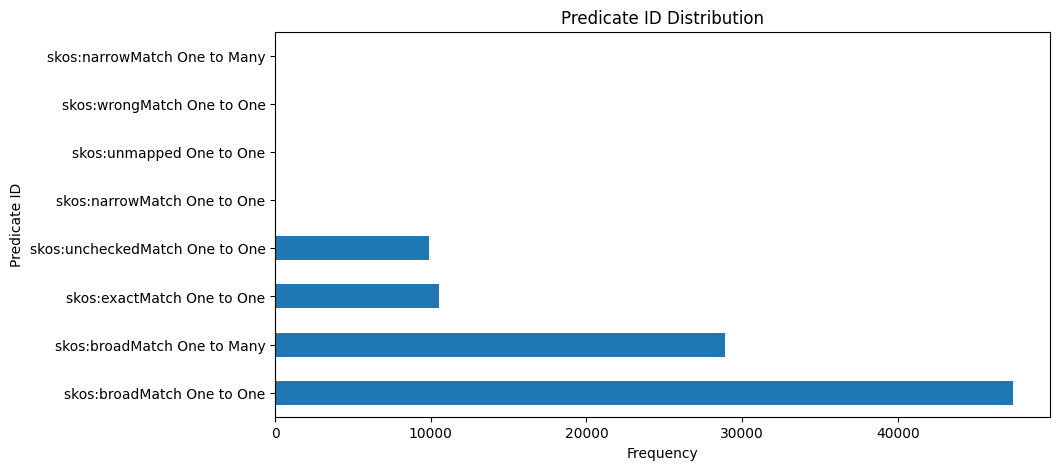

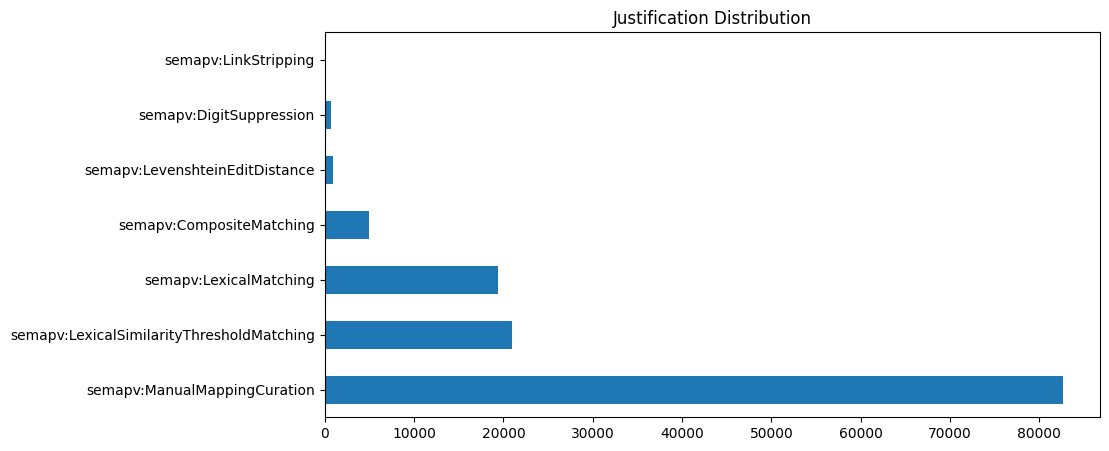

In [63]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# Define the get_predicates function
def get_predicates(x):
    if x:
        return 'One to Many'
    else:
        return 'One to One'

# Set the size of the plots
fig_size = (10, 5)

# Fetching the data from the given URL
url = 'https://github.com/TuftsCTSI/N3C/docs/icd10cm-to-ohdsi-mappings/ICD10CM-to-OHDSI-Mappings.xlsx?raw=true'
file_path = "temp_file.xlsm"

response = requests.get(url)
with open(file_path, 'wb') as f:
    f.write(response.content)

data = pd.read_excel(file_path, engine='openpyxl')

# Assuming 'data' is your dataframe to work with
df = data

# Create the predicate ID distribution
pred = df[['subject_id','predicate_id']].value_counts().rename_axis(['subject_id','predicate_id']).reset_index(name='counts')
pred['pred'] = pred['counts'].apply(lambda x: x > 1)
pred['predic_id'] = pred['pred'].map(get_predicates)
pred = pred[['subject_id','predicate_id','predic_id']].drop_duplicates()
pred['new_predicate_id'] = pred.predicate_id.astype(str)+' '+pred.predic_id
pred.new_predicate_id.value_counts().plot(kind='barh', figsize=fig_size, title='Predicate ID Distribution', xlabel='Frequency', ylabel='Predicate ID')
plt.show()

# Plot Justification Distribution
df.mapping_justification.value_counts().plot(kind='barh', figsize=fig_size, title='Justification Distribution')
plt.show()

### Confidence Per ICD Category 
A heatmap displays values in a matrix as colors. 
* X-axis: Represents "confidence" levels (between 1 and 0).
* Y-axis: Shows ICD categories.

Each cell's color indicates the frequency of a ICD category having a specific confidence level. This visualization helps:
* Spot ICD categories that predominantly align with certain confidence levels.
* Highlight areas needing more precise mappings or assess the robustness of current mappings.
In short, the heatmap offers a visual summary of how different ICD categories map across various confidence levels.

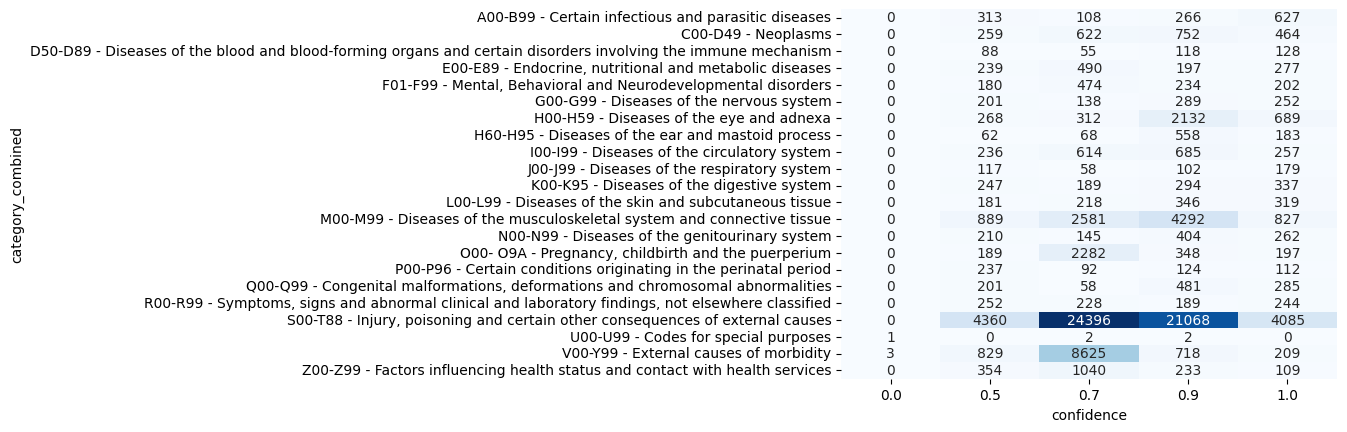

In [64]:
# Create a heatmap for subject category against confidence
sct = df[['subject_id','subject_category_range','subject_category','confidence']].drop_duplicates()

# Create a combined category field
sct['category_combined'] = sct['subject_category_range'] + " - " + sct['subject_category']

# Filter out rows with 'XXX'
sct = sct[sct['category_combined'] != 'XXX']

# Get value counts and reset index
sct = sct[['category_combined','confidence']].value_counts().rename_axis(['category_combined','confidence']).reset_index(name='count')

# Pivot for heatmap
sct = sct.pivot(index='category_combined', columns='confidence', values='count').fillna(0)

# Plot heatmap
sns.heatmap(sct, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.show()